<a href="https://colab.research.google.com/github/SoulINdUsT/machine-learning-lab/blob/main/HDR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install scikit-fuzzy numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 31.5 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset=pd.read_csv('/content/drive/MyDrive/DS/heart_disease_uci.csv')

In [4]:
dataset.head()
dataset.info()
dataset.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


Shape after cleaning: (745, 18)


,age,trestbps,chol,fbs,fbs_bin,num,target
0,63,145.0,233.0,True,1.0,0,0
1,67,160.0,286.0,False,0.0,2,1
2,67,120.0,229.0,False,0.0,1,1
3,37,130.0,250.0,False,0.0,0,0
4,41,130.0,204.0,False,0.0,0,0


Rows used: 745
Accuracy   : 52.48%
Sensitivity: 96.89%
Specificity: 4.74%
Precision  : 52.23%


/tmp/ipython-input-2670045519.py:87: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(mu_arr, x)
/tmp/ipython-input-2670045519.py:88: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if area == 0 else np.trapz(x * mu_arr, x) / area


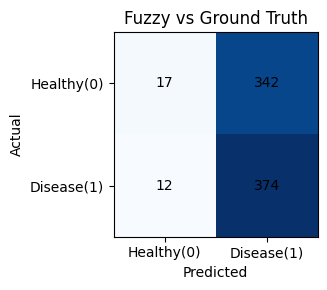

,age,trestbps,chol,fbs_bin,num,target,fuzzy_crisp,fuzzy_binary
0,63,145.0,233.0,1.0,0,0,1.300306,1
1,67,160.0,286.0,0.0,2,1,1.650668,1
2,67,120.0,229.0,0.0,1,1,1.000000,1
3,37,130.0,250.0,0.0,0,0,1.289394,1
4,41,130.0,204.0,0.0,0,0,1.000000,1
5,56,120.0,236.0,0.0,0,0,1.121540,1
6,62,140.0,268.0,0.0,3,1,1.330231,1
7,57,120.0,354.0,0.0,0,0,1.666675,1
8,63,130.0,254.0,0.0,2,1,1.319630,1
9,53,140.0,203.0,1.0,1,1,1.628577,1


Saved: /content/figs/confusion_matrix.png


In [5]:
# ========= Install & imports =========
!pip -q install scikit-fuzzy numpy matplotlib scikit-learn

import numpy as np, pandas as pd, skfuzzy as fuzz, matplotlib.pyplot as plt, os, re
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

assert 'dataset' in globals(), "Make sure your DataFrame is named `dataset`."

# ========= 1) Minimal preprocessing for your schema =========
df = dataset.copy()

# Keep only the columns we use
needed = ['age','trestbps','chol','fbs','num']
missing = [c for c in needed if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

# Coerce numerics
for col in ['age','trestbps','chol','num']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# fbs is object; normalize to {0,1}
def to_bin_fbs(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    # covers '1', 'true', 't', 'yes', '>120', etc.
    if re.match(r'^(1|true|t|yes|y|>?\s*120)$', s):
        return 1
    return 0
df['fbs_bin'] = df['fbs'].apply(to_bin_fbs)

# Drop rows without the core inputs/label
df = df.dropna(subset=['age','trestbps','chol','fbs_bin','num']).reset_index(drop=True)

# Impute any residual weird zeros if present (optional)
for col in ['trestbps','chol']:
    # treat 0 as missing for these physiological measures
    zmask = (df[col] == 0)
    if zmask.any():
        df.loc[zmask, col] = np.nan
        df[col] = df[col].fillna(df[col].median())

# Binary ground truth: UCI 'num' > 0 means disease present
df['target'] = (df['num'] > 0).astype(int)

print("Shape after cleaning:", df.shape)
display(df[['age','trestbps','chol','fbs','fbs_bin','num','target']].head())

# ========= 2) Define fuzzy universes & membership functions =========
x_age  = np.linspace(0, 75, 751)        # years
x_bp   = np.linspace(0, 200, 2001)      # mmHg
x_chol = np.linspace(0, 500, 5001)      # mg/dL
x_glu  = np.linspace(0, 400, 4001)      # mg/dL (proxy from fbs)
x_out  = np.linspace(0, 2, 401)         # 0=Healthy, 1=Stage1, 2=Stage2

# Age
age_young    = fuzz.trapmf(x_age, [0, 0, 30, 38])
age_mid      = fuzz.trimf(x_age, [34, 41, 45])
age_old      = fuzz.trimf(x_age, [40, 49, 58])
age_very_old = fuzz.trapmf(x_age, [53, 65, 75, 75])

# Blood Pressure
bp_normal = fuzz.trapmf(x_bp, [0, 0, 110, 130])     # <130
bp_med    = fuzz.trimf(x_bp, [120, 140, 159])       # 120–159
bp_high   = fuzz.trapmf(x_bp, [150, 170, 200, 200]) # 150–200

# Cholesterol
chol_norm = fuzz.trapmf(x_chol, [0, 0, 170, 200])
chol_med  = fuzz.trimf(x_chol, [190, 220, 250])
chol_high = fuzz.trimf(x_chol, [230, 275, 320])
chol_vhi  = fuzz.trapmf(x_chol, [280, 350, 500, 500])

# Diabetes (glucose proxy from fbs)
glu_norm = fuzz.trapmf(x_glu, [0, 0, 120, 160])
glu_diag = fuzz.trapmf(x_glu, [150, 200, 400, 400])

# Output classes
y_healthy = fuzz.trimf(x_out, [0, 0, 1])
y_stage1  = fuzz.trimf(x_out, [0.5, 1, 1.5])
y_stage2  = fuzz.trimf(x_out, [1, 2, 2])

def mu(xgrid, mf, x):  # fast interpolated degree
    return float(np.interp(x, xgrid, mf))

def centroid(x, mu_arr):
    area = np.trapz(mu_arr, x)
    return 0.0 if area == 0 else np.trapz(x * mu_arr, x) / area

# ========= 3) Rule base & classifier =========
def glucose_from_fbs_bin(fbs_bin):
    # UCI: fbs=1 means fasting blood sugar > 120 mg/dL
    return 180.0 if int(fbs_bin) == 1 else 100.0

def classify_row(age, bp, chol, fbs_bin):
    glu = glucose_from_fbs_bin(fbs_bin)

    # fuzzify
    A_y, A_m, A_o, A_vo = (mu(x_age, age_young, age),
                           mu(x_age, age_mid, age),
                           mu(x_age, age_old, age),
                           mu(x_age, age_very_old, age))
    BP_n, BP_m, BP_h = (mu(x_bp, bp_normal, bp),
                        mu(x_bp, bp_med, bp),
                        mu(x_bp, bp_high, bp))
    C_n, C_m, C_h, C_vh = (mu(x_chol, chol_norm, chol),
                           mu(x_chol, chol_med, chol),
                           mu(x_chol, chol_high, chol),
                           mu(x_chol, chol_vhi, chol))
    G_n, G_d = (mu(x_glu, glu_norm, glu),
                mu(x_glu, glu_diag, glu))

    # Rules (compact, interpretable)
    r1 = min(BP_n, C_n, G_n, max(A_y, A_m))                    # clearly healthy profile
    r2 = min(max(BP_m, C_m), G_n)                              # moderate vitals, normal glucose -> Stage1
    r3 = max(BP_h, max(C_h, C_vh))                             # high BP/Chol -> Stage2
    r4 = min(G_d, max(BP_m, C_m))                              # diabetic + moderate vitals -> Stage2
    r5 = min(A_vo, max(BP_m, C_m))                             # very old + moderate vitals -> Stage1
    r6 = min(A_vo, max(BP_h, max(C_h, C_vh)))                  # very old + high vitals -> Stage2
    r7 = min(A_o, max(BP_m, C_m), G_n)                         # old + moderate, normal glucose -> Stage1
    r8 = min(G_d, min(BP_n, C_n))                              # diabetic but otherwise normal -> Stage1 (early)

    # Implication + aggregation
    mu_H  = np.fmin(r1, y_healthy)
    mu_S1 = np.fmin(max(r2, r5, r7, r8), y_stage1)
    mu_S2 = np.fmin(max(r3, r4, r6), y_stage2)
    agg   = np.maximum(mu_H, np.maximum(mu_S1, mu_S2))

    crisp = centroid(x_out, agg)
    # collapse to binary for metrics: >=1 means disease present
    binary = 1 if crisp >= 0.5 else 0
    return crisp, binary

# Predict
crisp_scores, binary_preds = [], []
for _, r in df.iterrows():
    score, pred = classify_row(float(r['age']), float(r['trestbps']), float(r['chol']), int(r['fbs_bin']))
    crisp_scores.append(score); binary_preds.append(pred)

df['fuzzy_crisp']  = crisp_scores
df['fuzzy_binary'] = binary_preds

# ========= 4) Metrics =========
y_true = df['target'].values
y_pred = df['fuzzy_binary'].values

acc  = accuracy_score(y_true, y_pred)
sens = recall_score(y_true, y_pred)                         # TPR
spec = recall_score(1 - y_true, 1 - y_pred)                 # TNR
prec = precision_score(y_true, y_pred)

print(f"Rows used: {len(df)}")
print(f"Accuracy   : {acc*100:.2f}%")
print(f"Sensitivity: {sens*100:.2f}%")
print(f"Specificity: {spec*100:.2f}%")
print(f"Precision  : {prec*100:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
fig, ax = plt.subplots(figsize=(4,3))
im = ax.imshow(cm, cmap='Blues')
for (i,j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center')
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['Healthy(0)','Disease(1)'])
ax.set_yticklabels(['Healthy(0)','Disease(1)'])
ax.set_title("Fuzzy vs Ground Truth"); ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
plt.tight_layout()
os.makedirs("/content/figs", exist_ok=True)
plt.savefig("/content/figs/confusion_matrix.png", dpi=180); plt.show()

# Peek results
display(df[['age','trestbps','chol','fbs_bin','num','target','fuzzy_crisp','fuzzy_binary']].head(12))
print("Saved: /content/figs/confusion_matrix.png")


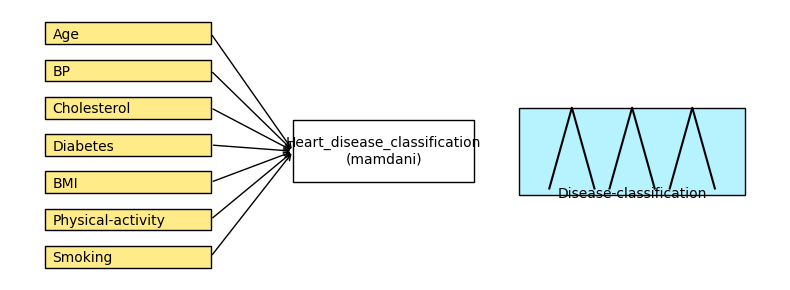

Saved: /content/figs/fig2_fuzzy_classification.png


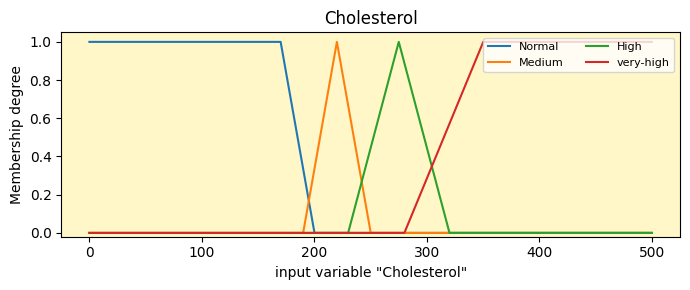

Saved: /content/figs/fig3_cholesterol.png


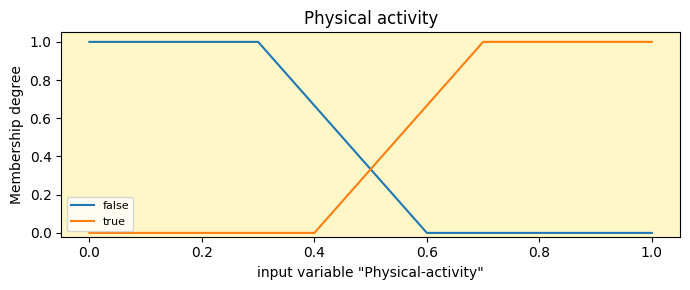

Saved: /content/figs/fig5_physical_activity.png


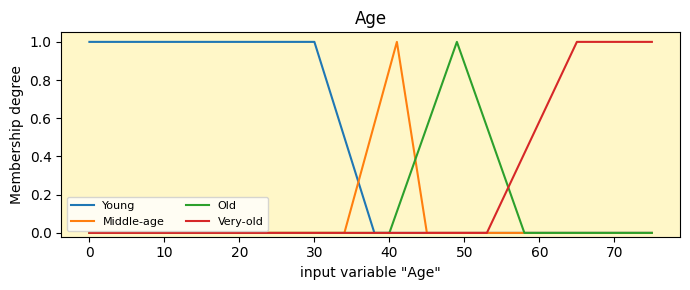

Saved: /content/figs/fig6_age.png


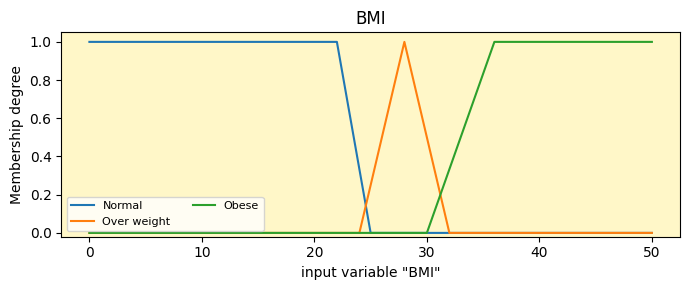

Saved: /content/figs/fig7_bmi.png


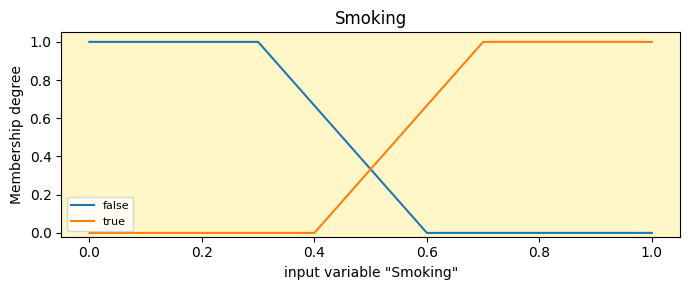

Saved: /content/figs/fig8_smoking.png


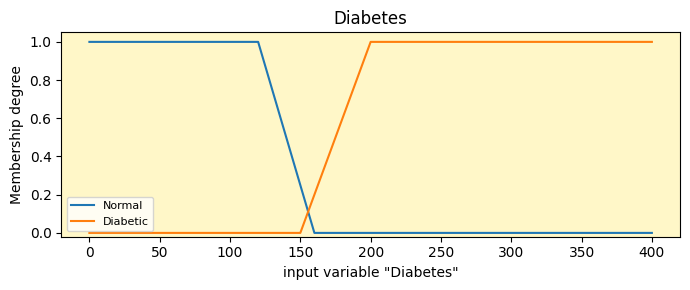

Saved: /content/figs/fig9_diabetes.png


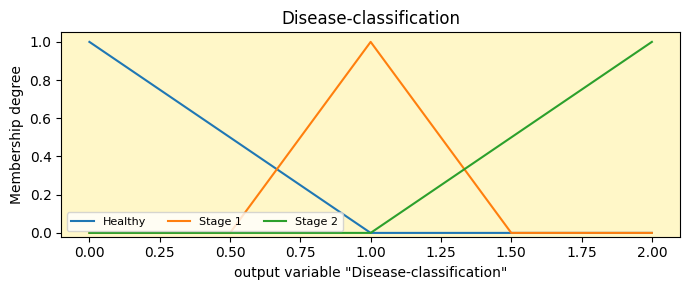

Saved: /content/figs/fig10_output.png


/tmp/ipython-input-2633816080.py:170: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(mu, x)
/tmp/ipython-input-2633816080.py:171: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if area == 0 else np.trapz(x * mu, x) / area


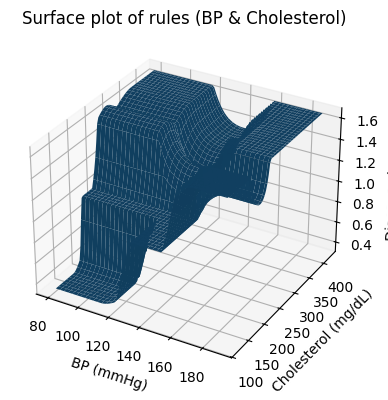

Saved: /content/figs/fig11_surface.png


In [6]:
# --- Install & imports
!pip -q install scikit-fuzzy numpy matplotlib

import numpy as np, skfuzzy as fuzz, matplotlib.pyplot as plt, os
from mpl_toolkits.mplot3d import Axes3D  # noqa

# --- Output folder
outdir = "/content/figs"; os.makedirs(outdir, exist_ok=True)

# --- A tiny helper to mimic the paper's yellow panels
def yellow_axes(ax, title, xlabel):
    ax.set_facecolor("#FFF7C8")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Membership degree")
    ax.set_ylim(-0.02, 1.05)
    ax.grid(False)

def savefig(name):
    plt.tight_layout(); plt.savefig(os.path.join(outdir, name), dpi=200); plt.show()
    print("Saved:", os.path.join(outdir, name))

# ------------------------------
# Universes (match the paper)
x_age   = np.linspace(0, 75, 751)        # years
x_bp    = np.linspace(0, 200, 2001)      # mmHg
x_chol  = np.linspace(0, 500, 5001)      # mg/dL
x_glu   = np.linspace(0, 400, 4001)      # mg/dL (diabetes proxy)
x_bmi   = np.linspace(0, 50, 501)        # kg/m^2
x_pa    = np.linspace(0, 1, 1001)        # physical activity (0..1)
x_smk   = np.linspace(0, 1, 1001)        # smoking (0..1)
x_out   = np.linspace(0, 2, 401)         # output 0..2

# Membership functions (as in the paper)
# Age
mf_age_young    = fuzz.trapmf(x_age, [0, 0, 30, 38])
mf_age_mid      = fuzz.trimf(x_age, [34, 41, 45])
mf_age_old      = fuzz.trimf(x_age, [40, 49, 58])
mf_age_very_old = fuzz.trapmf(x_age, [53, 65, 75, 75])

# Blood Pressure
mf_bp_norm = fuzz.trapmf(x_bp, [0, 0, 110, 130])
mf_bp_med  = fuzz.trimf(x_bp, [120, 140, 159])
mf_bp_high = fuzz.trapmf(x_bp, [150, 170, 200, 200])

# Cholesterol
mf_chol_norm = fuzz.trapmf(x_chol, [0, 0, 170, 200])
mf_chol_med  = fuzz.trimf(x_chol, [190, 220, 250])
mf_chol_high = fuzz.trimf(x_chol, [230, 275, 320])
mf_chol_vhi  = fuzz.trapmf(x_chol, [280, 350, 500, 500])

# Diabetes (glucose)
mf_glu_norm = fuzz.trapmf(x_glu, [0, 0, 120, 160])
mf_glu_diag = fuzz.trapmf(x_glu, [150, 200, 400, 400])

# BMI
mf_bmi_norm = fuzz.trapmf(x_bmi, [0, 0, 22, 25])
mf_bmi_over = fuzz.trimf(x_bmi, [24, 28, 32])
mf_bmi_obes = fuzz.trapmf(x_bmi, [30, 36, 50, 50])

# Physical activity
mf_pa_inact = fuzz.trapmf(x_pa, [0, 0, 0.3, 0.6])
mf_pa_act   = fuzz.trapmf(x_pa, [0.4, 0.7, 1, 1])

# Smoking
mf_smk_false = fuzz.trapmf(x_smk, [0, 0, 0.3, 0.6])
mf_smk_true  = fuzz.trapmf(x_smk, [0.4, 0.7, 1, 1])

# Output classes
mf_out_healthy = fuzz.trimf(x_out, [0, 0, 1])
mf_out_stage1  = fuzz.trimf(x_out, [0.5, 1, 1.5])
mf_out_stage2  = fuzz.trimf(x_out, [1, 2, 2])

# ------------------------------
# Fig.2 — simple system diagram (drawn with Matplotlib)
plt.figure(figsize=(8,3))
ax = plt.gca(); ax.axis('off'); ax.set_facecolor("#EEE")
# input blocks
labels = ["Age","BP","Cholesterol","Diabetes","BMI","Physical-activity","Smoking"]
for i,l in enumerate(labels):
    y = 0.9 - i*0.12
    ax.add_patch(plt.Rectangle((0.03,y-0.035), 0.22, 0.07, facecolor="#FFEB88", edgecolor="black"))
    ax.text(0.04, y-0.005, l, fontsize=10, va='center')
    ax.annotate("", xy=(0.36,0.52), xytext=(0.25,y), arrowprops=dict(arrowstyle="->"))
# Mamdani block
ax.add_patch(plt.Rectangle((0.36,0.42), 0.24, 0.2, facecolor="white", edgecolor="black"))
ax.text(0.48,0.52,"Heart_disease_classification\n(mamdani)", ha='center', va='center')
# Output panel
ax.add_patch(plt.Rectangle((0.66,0.38), 0.30, 0.28, facecolor="#B7F3FF", edgecolor="black"))
ax.text(0.81,0.64,"", ha='center')
ax.text(0.81,0.66,"", ha='center')
ax.text(0.81,0.40,"", ha='center')
ax.text(0.81,0.63,"", ha='center')
ax.text(0.81,0.52,"", ha='center')
ax.text(0.81,0.44,"", ha='center')
ax.text(0.81,0.68,"", ha='center')
# little triangles to mimic output MFs
tri_x = [0.70, 0.78, 0.86]; w=0.06; base=0.40; h=0.26
for k,x0 in enumerate(tri_x):
    ax.plot([x0, x0+w/2, x0+w], [base, base+h, base], color="black")
ax.text(0.81,0.37,"Disease-classification", ha='center', fontsize=10)
savefig("fig2_fuzzy_classification.png")

# ------------------------------
# Fig.3 — Cholesterol MFs
fig, ax = plt.subplots(figsize=(7,3))
ax.plot(x_chol, mf_chol_norm, label="Normal")
ax.plot(x_chol, mf_chol_med,  label="Medium")
ax.plot(x_chol, mf_chol_high, label="High")
ax.plot(x_chol, mf_chol_vhi,  label="very-high")
yellow_axes(ax, "Cholesterol", 'input variable "Cholesterol"')
ax.legend(loc="upper right", ncol=2, fontsize=8)
savefig("fig3_cholesterol.png")

# Fig.5 — Physical activity
fig, ax = plt.subplots(figsize=(7,3))
ax.plot(x_pa, mf_pa_inact, label="false")
ax.plot(x_pa, mf_pa_act,   label="true")
yellow_axes(ax, "Physical activity", 'input variable "Physical-activity"')
ax.legend(fontsize=8)
savefig("fig5_physical_activity.png")

# Fig.6 — Age
fig, ax = plt.subplots(figsize=(7,3))
ax.plot(x_age, mf_age_young,    label="Young")
ax.plot(x_age, mf_age_mid,      label="Middle-age")
ax.plot(x_age, mf_age_old,      label="Old")
ax.plot(x_age, mf_age_very_old, label="Very-old")
yellow_axes(ax, "Age", 'input variable "Age"')
ax.legend(ncol=2, fontsize=8)
savefig("fig6_age.png")

# Fig.7 — BMI
fig, ax = plt.subplots(figsize=(7,3))
ax.plot(x_bmi, mf_bmi_norm, label="Normal")
ax.plot(x_bmi, mf_bmi_over, label="Over weight")
ax.plot(x_bmi, mf_bmi_obes, label="Obese")
yellow_axes(ax, "BMI", 'input variable "BMI"')
ax.legend(ncol=2, fontsize=8)
savefig("fig7_bmi.png")

# Fig.8 — Smoking
fig, ax = plt.subplots(figsize=(7,3))
ax.plot(x_smk, mf_smk_false, label="false")
ax.plot(x_smk, mf_smk_true,  label="true")
yellow_axes(ax, "Smoking", 'input variable "Smoking"')
ax.legend(fontsize=8)
savefig("fig8_smoking.png")

# Fig.9 — Diabetes
fig, ax = plt.subplots(figsize=(7,3))
ax.plot(x_glu, mf_glu_norm, label="Normal")
ax.plot(x_glu, mf_glu_diag, label="Diabetic")
yellow_axes(ax, "Diabetes", 'input variable "Diabetes"')
ax.legend(fontsize=8)
savefig("fig9_diabetes.png")

# Fig.10 — Output variable
fig, ax = plt.subplots(figsize=(7,3))
ax.plot(x_out, mf_out_healthy, label="Healthy")
ax.plot(x_out, mf_out_stage1,  label="Stage 1")
ax.plot(x_out, mf_out_stage2,  label="Stage 2")
yellow_axes(ax, "Disease-classification", 'output variable "Disease-classification"')
ax.legend(ncol=3, fontsize=8)
savefig("fig10_output.png")

# ------------------------------
# Fig.11 — 3D rule surface (BP vs Cholesterol -> output)
def centroid(x, mu):
    area = np.trapz(mu, x)
    return 0.0 if area == 0 else np.trapz(x * mu, x) / area

bp_grid   = np.linspace(80, 190, 80)
chol_grid = np.linspace(120, 420, 80)
Z = np.zeros((len(bp_grid), len(chol_grid)))

for i,b in enumerate(bp_grid):
    # lookup degrees
    bn = np.interp(b, x_bp, mf_bp_norm)
    bm = np.interp(b, x_bp, mf_bp_med)
    bh = np.interp(b, x_bp, mf_bp_high)
    for j,c in enumerate(chol_grid):
        cn  = np.interp(c, x_chol, mf_chol_norm)
        cm  = np.interp(c, x_chol, mf_chol_med)
        ch  = np.interp(c, x_chol, mf_chol_high)
        cvh = np.interp(c, x_chol, mf_chol_vhi)
        # simple, interpretable rules
        r1 = min(bn, cn)                              # -> Healthy
        r2 = max(bm, cm)                              # -> Stage1
        r3 = max(bh, max(ch, cvh))                    # -> Stage2

        mu_H  = np.fmin(r1, mf_out_healthy)
        mu_S1 = np.fmin(r2, mf_out_stage1)
        mu_S2 = np.fmin(r3, mf_out_stage2)
        agg = np.maximum(mu_H, np.maximum(mu_S1, mu_S2))
        Z[i,j] = centroid(x_out, agg)

B, C = np.meshgrid(chol_grid, bp_grid)
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(C, B, Z, linewidth=0, antialiased=True)
ax.set_xlabel("BP (mmHg)"); ax.set_ylabel("Cholesterol (mg/dL)"); ax.set_zlabel("Disease class (0..2)")
ax.set_title("Surface plot of rules (BP & Cholesterol)")
savefig("fig11_surface.png")


Rows after cleaning: 744


,age,trestbps,chol,fbs,fbs_bin,restecg,restecg_num,exang,exang_bin,thalch,num,target
0,63,145.0,233.0,True,1.0,lv hypertrophy,1.0,False,0.0,150.0,0,0
1,67,160.0,286.0,False,0.0,lv hypertrophy,1.0,True,1.0,108.0,2,1
2,67,120.0,229.0,False,0.0,lv hypertrophy,1.0,True,1.0,129.0,1,1
3,37,130.0,250.0,False,0.0,normal,0.0,False,0.0,187.0,0,0
4,41,130.0,204.0,False,0.0,lv hypertrophy,1.0,False,0.0,172.0,0,0


/tmp/ipython-input-1975896991.py:122: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  A = np.trapz(muarr, x)
/tmp/ipython-input-1975896991.py:123: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if A==0 else np.trapz(x*muarr, x)/A


Accuracy: 53.63% | Sensitivity: 98.96% | Specificity: 5.01% | Precision: 52.77%


/tmp/ipython-input-1975896991.py:122: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  A = np.trapz(muarr, x)
/tmp/ipython-input-1975896991.py:123: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if A==0 else np.trapz(x*muarr, x)/A


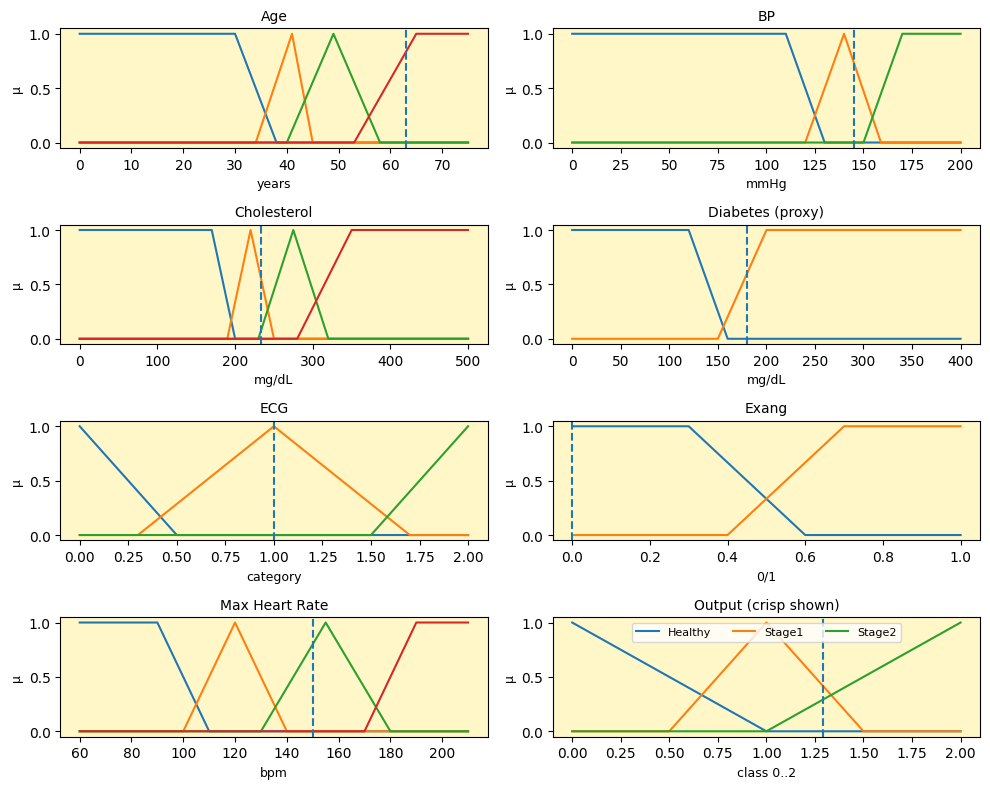

Rule firing strengths: {'r1': 0.0, 'r2': 0.0, 'r3': 0.06666666666666667, 'r4': 0.6, 'r5': 0.0, 'r6': 0.8333333333333334, 'r7': 0.06666666666666667, 'r8': 0.0}
Saved: /content/figs/rule_viewer_row_0.png | Crisp output: 1.293 | Binary: 1


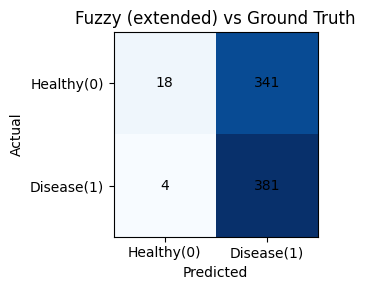

All images saved in: /content/figs


In [7]:
# --- Install deps
!pip -q install scikit-fuzzy numpy matplotlib scikit-learn

import numpy as np, pandas as pd, skfuzzy as fuzz, matplotlib.pyplot as plt, os, re
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Use your loaded DataFrame
df = dataset.copy()

# ---------- Clean & map columns ----------
# Use thalch or thalach (some files use either spelling)
hr_col = 'thalch' if 'thalch' in df.columns else ('thalach' if 'thalach' in df.columns else None)
if hr_col is None:
    raise ValueError("Neither 'thalch' nor 'thalach' found.")

# Coerce types
for c in ['age','trestbps','chol','num']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# fbs (object) -> 0/1
def map_fbs(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    return 1 if re.match(r'^(1|true|t|yes|y|>?\s*120)$', s) else 0
df['fbs_bin'] = df['fbs'].apply(map_fbs)

# restecg (object) -> {0: normal, 1: ST-T abn, 2: LVH}
def map_restecg(x):
    if pd.isna(x): return np.nan
    try:
        v = float(str(x).strip());
        if v in [0,1,2]: return int(v)
    except: pass
    s = str(x).strip().lower()
    if 'normal' in s: return 0
    if 'st' in s or 't' in s or 'abnorm' in s: return 1
    if 'lvh' in s or 'hypertrophy' in s: return 2
    return np.nan
df['restecg_num'] = df['restecg'].apply(map_restecg)

# exang (object) -> 0/1
def map_exang(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    return 1 if s in ['1','yes','true','t','y'] else 0
df['exang_bin'] = df['exang'].apply(map_exang)

# Heart rate
df[hr_col] = pd.to_numeric(df[hr_col], errors='coerce')

# keep rows with all needed inputs
use_cols = ['age','trestbps','chol','fbs_bin','restecg_num','exang_bin',hr_col,'num']
df = df.dropna(subset=use_cols).reset_index(drop=True)

# treat zeros as missing for vitals & impute
for c in ['trestbps','chol',hr_col]:
    z = df[c] == 0
    if z.any():
        df.loc[z, c] = np.nan
        df[c] = df[c].fillna(df[c].median())

# Binary ground-truth: disease present if num > 0
df['target'] = (df['num'] > 0).astype(int)

print("Rows after cleaning:", len(df))
display(df[['age','trestbps','chol','fbs','fbs_bin','restecg','restecg_num','exang','exang_bin',hr_col,'num','target']].head())

# ---------- FUZZY UNIVERSES ----------
x_age   = np.linspace(0, 75, 751)
x_bp    = np.linspace(0, 200, 2001)
x_chol  = np.linspace(0, 500, 5001)
x_glu   = np.linspace(0, 400, 4001)
x_ecg   = np.linspace(0, 2, 201)
x_ex    = np.linspace(0, 1, 201)
x_hr    = np.linspace(60, 210, 751)
x_out   = np.linspace(0, 2, 401)   # 0 Healthy, 1 Stage1, 2 Stage2

# Age
mf_age_young    = fuzz.trapmf(x_age,[0,0,30,38])
mf_age_mid      = fuzz.trimf(x_age,[34,41,45])
mf_age_old      = fuzz.trimf(x_age,[40,49,58])
mf_age_very_old = fuzz.trapmf(x_age,[53,65,75,75])

# BP
mf_bp_norm = fuzz.trapmf(x_bp,[0,0,110,130])
mf_bp_med  = fuzz.trimf(x_bp,[120,140,159])
mf_bp_high = fuzz.trapmf(x_bp,[150,170,200,200])

# Chol
mf_ch_norm = fuzz.trapmf(x_chol,[0,0,170,200])
mf_ch_med  = fuzz.trimf(x_chol,[190,220,250])
mf_ch_high = fuzz.trimf(x_chol,[230,275,320])
mf_ch_vhi  = fuzz.trapmf(x_chol,[280,350,500,500])

# Glucose (from fbs)
mf_gl_norm = fuzz.trapmf(x_glu,[0,0,120,160])
mf_gl_diag = fuzz.trapmf(x_glu,[150,200,400,400])

# ECG (0 normal, 1 minor, 2 major)
mf_ecg_norm  = fuzz.trapmf(x_ecg,[-0.2,0,0,0.5])
mf_ecg_minor = fuzz.trimf(x_ecg,[0.3,1.0,1.7])
mf_ecg_major = fuzz.trapmf(x_ecg,[1.5,2,2,2.2])

# Exang (0 no, 1 yes)
mf_ex_no  = fuzz.trapmf(x_ex,[0,0,0.3,0.6])
mf_ex_yes = fuzz.trapmf(x_ex,[0.4,0.7,1,1])

# Heart rate (max achieved): low HR at max exercise is a risk sign
mf_hr_vlow = fuzz.trapmf(x_hr,[60,60,90,110])
mf_hr_low  = fuzz.trimf(x_hr,[100,120,140])
mf_hr_norm = fuzz.trimf(x_hr,[130,155,180])
mf_hr_high = fuzz.trapmf(x_hr,[170,190,210,210])

# Output
mf_out_H = fuzz.trimf(x_out,[0,0,1])
mf_out_S1= fuzz.trimf(x_out,[0.5,1,1.5])
mf_out_S2= fuzz.trimf(x_out,[1,2,2])

# helpers
def mu(xg, mf, x): return float(np.interp(x, xg, mf))
def centroid(x, muarr):
    A = np.trapz(muarr, x)
    return 0.0 if A==0 else np.trapz(x*muarr, x)/A

def glucose_from_fbs_bin(b): return 180.0 if int(b)==1 else 100.0

# ---------- RULE BASE (now using ECG, HR, Exang) ----------
def classify_row(r):
    age = float(r['age']); bp = float(r['trestbps']); chol=float(r['chol'])
    glu = glucose_from_fbs_bin(int(r['fbs_bin']))
    ecg = float(r['restecg_num']); ex  = float(r['exang_bin']); hr = float(r[hr_col])

    # fuzzify
    Ay,Am,Ao,Avo = (mu(x_age,mf_age_young,age), mu(x_age,mf_age_mid,age),
                    mu(x_age,mf_age_old,age),   mu(x_age,mf_age_very_old,age))
    BPn,BPm,BPh   = (mu(x_bp,mf_bp_norm,bp), mu(x_bp,mf_bp_med,bp), mu(x_bp,mf_bp_high,bp))
    Cn,Cm,Ch,Cvh  = (mu(x_chol,mf_ch_norm,chol), mu(x_chol,mf_ch_med,chol),
                     mu(x_chol,mf_ch_high,chol), mu(x_chol,mf_ch_vhi,chol))
    Gn,Gd         = (mu(x_glu,mf_gl_norm,glu), mu(x_glu,mf_gl_diag,glu))
    ECGn,ECGm,ECGM= (mu(x_ecg,mf_ecg_norm,ecg), mu(x_ecg,mf_ecg_minor,ecg), mu(x_ecg,mf_ecg_major,ecg))
    EXn,EXy       = (mu(x_ex,mf_ex_no,ex), mu(x_ex,mf_ex_yes,ex))
    HRv,HRl,HRn,HRh = (mu(x_hr,mf_hr_vlow,hr), mu(x_hr,mf_hr_low,hr),
                       mu(x_hr,mf_hr_norm,hr), mu(x_hr,mf_hr_high,hr))

    # core rules (weights = firing strengths)
    r1 = min(BPn, Cn, Gn, ECGn, EXn, max(Ay,Am), HRn)                 # clearly healthy
    r2 = min(max(BPm, Cm), Gn, max(ECGn, HRn))                         # moderate vitals -> Stage1
    r3 = max(BPh, max(Ch, Cvh), ECGM)                                  # severe vitals or major ECG -> Stage2
    r4 = min(Gd, max(BPm, Cm, ECGm))                                   # diabetic + moderate/ECG minor -> Stage2
    r5 = min(EXy, max(HRv, HRl))                                       # angina + low/very-low HR -> Stage2
    r6 = min(Avo, max(BPm, Cm, ECGm))                                  # very old + moderate -> Stage1
    r7 = min(Avo, max(BPh, Ch, Cvh, ECGM))                             # very old + severe -> Stage2
    r8 = min(Ao, HRl, EXn, Gn)                                         # old + low HR but no angina/diabetes -> Stage1

    muH  = np.fmin(r1, mf_out_H)
    muS1 = np.fmin(max(r2, r6, r8), mf_out_S1)
    muS2 = np.fmin(max(r3, r4, r5, r7), mf_out_S2)

    agg = np.maximum(muH, np.maximum(muS1, muS2))
    crisp = centroid(x_out, agg)
    binary = 1 if crisp >= 0.5 else 0
    return crisp, binary, dict(
        r1=r1,r2=r2,r3=r3,r4=r4,r5=r5,r6=r6,r7=r7,r8=r8
    )

# ---------- Predict & metrics ----------
scores, preds = [], []
for _, row in df.iterrows():
    s, b, _ = classify_row(row)
    scores.append(s); preds.append(b)

df['fuzzy_crisp']  = scores
df['fuzzy_binary'] = preds

y_true = df['target'].values
y_pred = df['fuzzy_binary'].values

acc  = accuracy_score(y_true, y_pred)
sens = recall_score(y_true, y_pred)
spec = recall_score(1 - y_true, 1 - y_pred)
prec = precision_score(y_true, y_pred)

print(f"Accuracy: {acc*100:.2f}% | Sensitivity: {sens*100:.2f}% | Specificity: {spec*100:.2f}% | Precision: {prec*100:.2f}%")

# ---------- MATLAB-like "Rule Viewer" for one row ----------
outdir = "/content/figs"; os.makedirs(outdir, exist_ok=True)

def rule_viewer(idx):
    r = df.iloc[idx]
    crisp, _, fires = classify_row(r)

    # a small helper for the yellow background
    def yellow(ax, title, xlabel):
        ax.set_facecolor("#FFF7C8")
        ax.set_title(title, fontsize=10)
        ax.set_xlabel(xlabel, fontsize=9)
        ax.set_ylabel("μ", fontsize=9)
        ax.set_ylim(-0.05, 1.05)

    fig, axs = plt.subplots(4, 2, figsize=(10,8))
    axs = axs.ravel()

    # Age
    axs[0].plot(x_age, mf_age_young); axs[0].plot(x_age, mf_age_mid)
    axs[0].plot(x_age, mf_age_old);   axs[0].plot(x_age, mf_age_very_old)
    axs[0].axvline(r['age'], linestyle='--'); yellow(axs[0],"Age",'years')

    # BP
    axs[1].plot(x_bp,mf_bp_norm); axs[1].plot(x_bp,mf_bp_med); axs[1].plot(x_bp,mf_bp_high)
    axs[1].axvline(r['trestbps'], linestyle='--'); yellow(axs[1],"BP",'mmHg')

    # Chol
    axs[2].plot(x_chol,mf_ch_norm); axs[2].plot(x_chol,mf_ch_med); axs[2].plot(x_chol,mf_ch_high); axs[2].plot(x_chol,mf_ch_vhi)
    axs[2].axvline(r['chol'], linestyle='--'); yellow(axs[2],"Cholesterol",'mg/dL')

    # Glucose proxy
    glu = glucose_from_fbs_bin(int(r['fbs_bin']))
    axs[3].plot(x_glu,mf_gl_norm); axs[3].plot(x_glu,mf_gl_diag)
    axs[3].axvline(glu, linestyle='--'); yellow(axs[3],"Diabetes (proxy)",'mg/dL')

    # ECG
    axs[4].plot(x_ecg,mf_ecg_norm); axs[4].plot(x_ecg,mf_ecg_minor); axs[4].plot(x_ecg,mf_ecg_major)
    axs[4].axvline(r['restecg_num'], linestyle='--'); yellow(axs[4],"ECG",'category')

    # Exang
    axs[5].plot(x_ex,mf_ex_no); axs[5].plot(x_ex,mf_ex_yes)
    axs[5].axvline(r['exang_bin'], linestyle='--'); yellow(axs[5],"Exang",'0/1')

    # Heart Rate
    axs[6].plot(x_hr,mf_hr_vlow); axs[6].plot(x_hr,mf_hr_low); axs[6].plot(x_hr,mf_hr_norm); axs[6].plot(x_hr,mf_hr_high)
    axs[6].axvline(r[hr_col], linestyle='--'); yellow(axs[6],"Max Heart Rate",'bpm')

    # Output
    axs[7].plot(x_out, mf_out_H, label='Healthy')
    axs[7].plot(x_out, mf_out_S1, label='Stage1')
    axs[7].plot(x_out, mf_out_S2, label='Stage2')
    axs[7].axvline(crisp, linestyle='--')
    yellow(axs[7],"Output (crisp shown)",'class 0..2')
    axs[7].legend(fontsize=8, ncol=3)

    plt.tight_layout()
    path = os.path.join(outdir, f"rule_viewer_row_{idx}.png")
    plt.savefig(path, dpi=200); plt.show()
    print("Rule firing strengths:", fires)
    print("Saved:", path, "| Crisp output:", round(crisp,3), "| Binary:", 1 if crisp>=0.5 else 0)

# Example: show row 0 (change index to inspect others)
rule_viewer(0)

# Also save a confusion matrix for the extended model
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
plt.figure(figsize=(4,3))
plt.imshow(cm, cmap='Blues');
for (i,j), v in np.ndenumerate(cm): plt.text(j,i,str(v),ha='center',va='center')
plt.xticks([0,1],['Healthy(0)','Disease(1)']); plt.yticks([0,1],['Healthy(0)','Disease(1)'])
plt.title("Fuzzy (extended) vs Ground Truth"); plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.savefig(os.path.join(outdir,"confusion_matrix_extended.png"), dpi=200); plt.show()
print("All images saved in:", outdir)


/tmp/ipython-input-4250339877.py:66: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  A = np.trapz(mu_arr, x)
/tmp/ipython-input-4250339877.py:67: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if A == 0 else np.trapz(x*mu_arr, x)/A


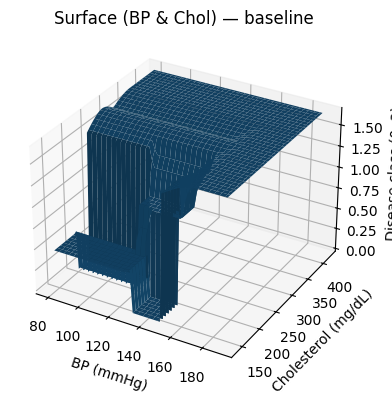

Saved: /content/figs/surface_bp_chol_baseline.png


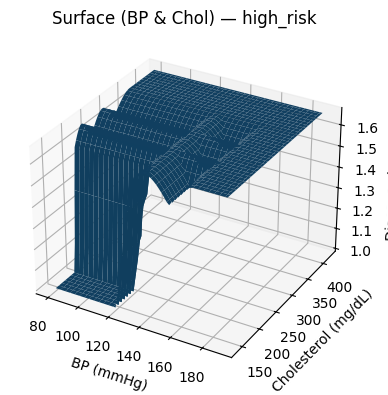

Saved: /content/figs/surface_bp_chol_high_risk.png


In [8]:
# ===========================
# Surface-of-rules (Colab cell)
# ===========================
!pip -q install scikit-fuzzy numpy matplotlib

import numpy as np, skfuzzy as fuzz, matplotlib.pyplot as plt, os
from mpl_toolkits.mplot3d import Axes3D  # noqa

outdir = "/content/figs"; os.makedirs(outdir, exist_ok=True)

# ---------- 1) Universes ----------
x_age   = np.linspace(0, 75, 751)        # yrs
x_bp    = np.linspace(0, 200, 2001)      # mmHg
x_chol  = np.linspace(0, 500, 5001)      # mg/dL
x_glu   = np.linspace(0, 400, 4001)      # mg/dL
x_bmi   = np.linspace(15, 50, 701)       # kg/m^2
x_pa    = np.linspace(0, 1, 1001)        # 0..1
x_smk   = np.linspace(0, 1, 1001)        # 0..1
x_out   = np.linspace(0, 2, 401)         # 0=Healthy,1=Stage1,2=Stage2

# ---------- 2) Membership functions (as in the paper) ----------
# Age
mf_age_young    = fuzz.trapmf(x_age, [0, 0, 30, 38])
mf_age_mid      = fuzz.trimf(x_age, [34, 41, 45])
mf_age_old      = fuzz.trimf(x_age, [40, 49, 58])
mf_age_very_old = fuzz.trapmf(x_age, [53, 65, 75, 75])

# BP
mf_bp_norm = fuzz.trapmf(x_bp, [0, 0, 110, 130])
mf_bp_med  = fuzz.trimf(x_bp, [120, 140, 159])
mf_bp_high = fuzz.trapmf(x_bp, [150, 170, 200, 200])

# Cholesterol
mf_chol_norm = fuzz.trapmf(x_chol, [0, 0, 170, 200])
mf_chol_med  = fuzz.trimf(x_chol, [190, 220, 250])
mf_chol_high = fuzz.trimf(x_chol, [230, 275, 320])
mf_chol_vhi  = fuzz.trapmf(x_chol, [280, 350, 500, 500])

# Diabetes (glucose)
mf_glu_norm = fuzz.trapmf(x_glu, [0, 0, 120, 160])
mf_glu_diag = fuzz.trapmf(x_glu, [150, 200, 400, 400])

# BMI
mf_bmi_norm = fuzz.trapmf(x_bmi, [15, 15, 22, 25])
mf_bmi_med  = fuzz.trimf(x_bmi, [24, 28, 32])      # "medium" ≈ overweight
mf_bmi_obes = fuzz.trapmf(x_bmi, [30, 36, 50, 50])

# Physical activity
mf_pa_inact = fuzz.trapmf(x_pa, [0, 0, 0.3, 0.6])
mf_pa_act   = fuzz.trapmf(x_pa, [0.4, 0.7, 1, 1])

# Smoking
mf_smk_false = fuzz.trapmf(x_smk, [0, 0, 0.3, 0.6])
mf_smk_true  = fuzz.trapmf(x_smk, [0.4, 0.7, 1, 1])

# Output sets
mf_out_H  = fuzz.trimf(x_out, [0, 0, 1])
mf_out_S1 = fuzz.trimf(x_out, [0.5, 1, 1.5])
mf_out_S2 = fuzz.trimf(x_out, [1, 2, 2])

# ---------- 3) Utilities ----------
def mu(xg, mf, x):
    return float(np.interp(x, xg, mf))

def centroid(x, mu_arr):
    A = np.trapz(mu_arr, x)
    return 0.0 if A == 0 else np.trapz(x*mu_arr, x)/A

# ---------- 4) Rule-base (mirrors the logic in your figure text) ----------
# We implement representative rules in the same spirit:
# - Very-old + High BP + High/Very-high Chol + Diabetic + Obese + Inactive + Smoker  -> Stage2
# - Old/Middle with Medium vitals etc. -> Stage1
# - Clearly normal profile -> Healthy
def fis_crisp(age, bp, chol, glu, bmi, pa, smk):
    # fuzzify
    Ay, Am, Ao, Avo = (mu(x_age, mf_age_young, age),
                       mu(x_age, mf_age_mid, age),
                       mu(x_age, mf_age_old, age),
                       mu(x_age, mf_age_very_old, age))
    BPn, BPm, BPh   = (mu(x_bp, mf_bp_norm, bp),
                       mu(x_bp, mf_bp_med,  bp),
                       mu(x_bp, mf_bp_high, bp))
    Cn, Cm, Ch, Cvh = (mu(x_chol, mf_chol_norm, chol),
                       mu(x_chol, mf_chol_med,  chol),
                       mu(x_chol, mf_chol_high, chol),
                       mu(x_chol, mf_chol_vhi,  chol))
    Gn, Gd          = (mu(x_glu, mf_glu_norm, glu),
                       mu(x_glu, mf_glu_diag, glu))
    Bn, Bm, Bo      = (mu(x_bmi, mf_bmi_norm, bmi),
                       mu(x_bmi, mf_bmi_med,  bmi),
                       mu(x_bmi, mf_bmi_obes, bmi))
    Pn, Pa          = (mu(x_pa,  mf_pa_inact, pa),
                       mu(x_pa,  mf_pa_act,   pa))
    Sn, Sy          = (mu(x_smk, mf_smk_false, smk),
                       mu(x_smk, mf_smk_true,  smk))

    # ---- Rules (min for AND, max for OR) ----
    rules_H = []
    rules_S1 = []
    rules_S2 = []

    # H1: Normal vitals, active, non-smoker -> Healthy
    rules_H.append(min(BPn, Cn, Gn, Bn, Pa, Sn, max(Ay, Am, Ao)))

    # H2: Any age + BP Normal + Chol Normal + non-diabetic + BMI Medium + Active + non-smoker -> Healthy
    rules_H.append(min(BPn, Cn, Gn, Bm, Pa, Sn))

    # S1 group (early-stage, moderate risk)
    # S1-1: Young/Middle + BP Medium + Chol Medium + non-diabetic + BMI Medium + Inactive -> Stage1
    rules_S1.append(min(max(Ay, Am), BPm, Cm, Gn, Bm, Pn))
    # S1-2: Old + BP Medium + Chol Medium + non-diabetic + BMI Medium + Active + non-smoker -> Stage1
    rules_S1.append(min(Ao, BPm, Cm, Gn, Bm, Pa, Sn))
    # S1-3: Very-old + (BP Medium or Chol Medium) + non-diabetic -> Stage1
    rules_S1.append(min(Avo, max(BPm, Cm), Gn))
    # S1-4: Diabetic but (BP Normal & Chol Normal) -> Stage1 (early alert)
    rules_S1.append(min(Gd, BPn, Cn))

    # S2 group (advanced-stage, high risk)
    # S2-1: Any age + (BP High or Chol High/Very-high) -> Stage2
    rules_S2.append(max(BPh, max(Ch, Cvh)))
    # S2-2: Diabetic + (BP Medium or Chol Medium) -> Stage2
    rules_S2.append(min(Gd, max(BPm, Cm)))
    # S2-3: Very-old + High BP + (High or VHigh Chol) -> Stage2
    rules_S2.append(min(Avo, BPh, max(Ch, Cvh)))
    # S2-4: Very-old + Obese + Inactive + Smoker + (High BP or High/VHigh Chol) -> Stage2
    rules_S2.append(min(Avo, Bo, Pn, Sy, max(BPh, max(Ch, Cvh))))
    # S2-5: Old + Obese + Inactive + (High BP and High/VHigh Chol) -> Stage2
    rules_S2.append(min(Ao, Bo, Pn, min(BPh, max(Ch, Cvh))))

    # Implication (clip targets) and aggregation
    mu_H  = np.fmin(max(rules_H)  if rules_H  else 0, mf_out_H)
    mu_S1 = np.fmin(max(rules_S1) if rules_S1 else 0, mf_out_S1)
    mu_S2 = np.fmin(max(rules_S2) if rules_S2 else 0, mf_out_S2)

    agg = np.maximum(mu_H, np.maximum(mu_S1, mu_S2))
    return centroid(x_out, agg)  # crisp 0..2

# ---------- 5) Surface plotting helper ----------
def plot_surface_BP_CHOL(tag, fixed):
    """
    fixed: dict with keys age, glu, bmi, pa, smk  (BP & CHOL vary on the surface)
    """
    bp_grid   = np.linspace(80, 190, 70)
    chol_grid = np.linspace(140, 420, 70)
    Z = np.zeros((len(bp_grid), len(chol_grid)))

    for i, bp in enumerate(bp_grid):
        for j, ch in enumerate(chol_grid):
            Z[i, j] = fis_crisp(fixed['age'], bp, ch, fixed['glu'], fixed['bmi'], fixed['pa'], fixed['smk'])

    B, C = np.meshgrid(chol_grid, bp_grid)
    fig = plt.figure(figsize=(7,4))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(BP:=C, CH:=B, Z, linewidth=0, antialiased=True)
    ax.set_xlabel("BP (mmHg)"); ax.set_ylabel("Cholesterol (mg/dL)"); ax.set_zlabel("Disease class (0..2)")
    ttl = f"Surface (BP & Chol) — {tag}"
    ax.set_title(ttl)
    path = os.path.join(outdir, f"surface_bp_chol_{tag.replace(' ','_').lower()}.png")
    plt.tight_layout(); plt.savefig(path, dpi=220); plt.show()
    print("Saved:", path)

# ---------- 6) Surfaces like in the paper ----------
# Scenario A: average-risk baseline (middle age, non-diabetic, normal BMI, active, non-smoker)
baseline = dict(age=45, glu=100, bmi=24.5, pa=0.7, smk=0.0)
plot_surface_BP_CHOL("baseline", baseline)

# Scenario B: high-risk (very-old, diabetic, obese, inactive, smoker)
highrisk = dict(age=68, glu=220, bmi=33, pa=0.2, smk=0.9)
plot_surface_BP_CHOL("high_risk", highrisk)


Total rules: 44


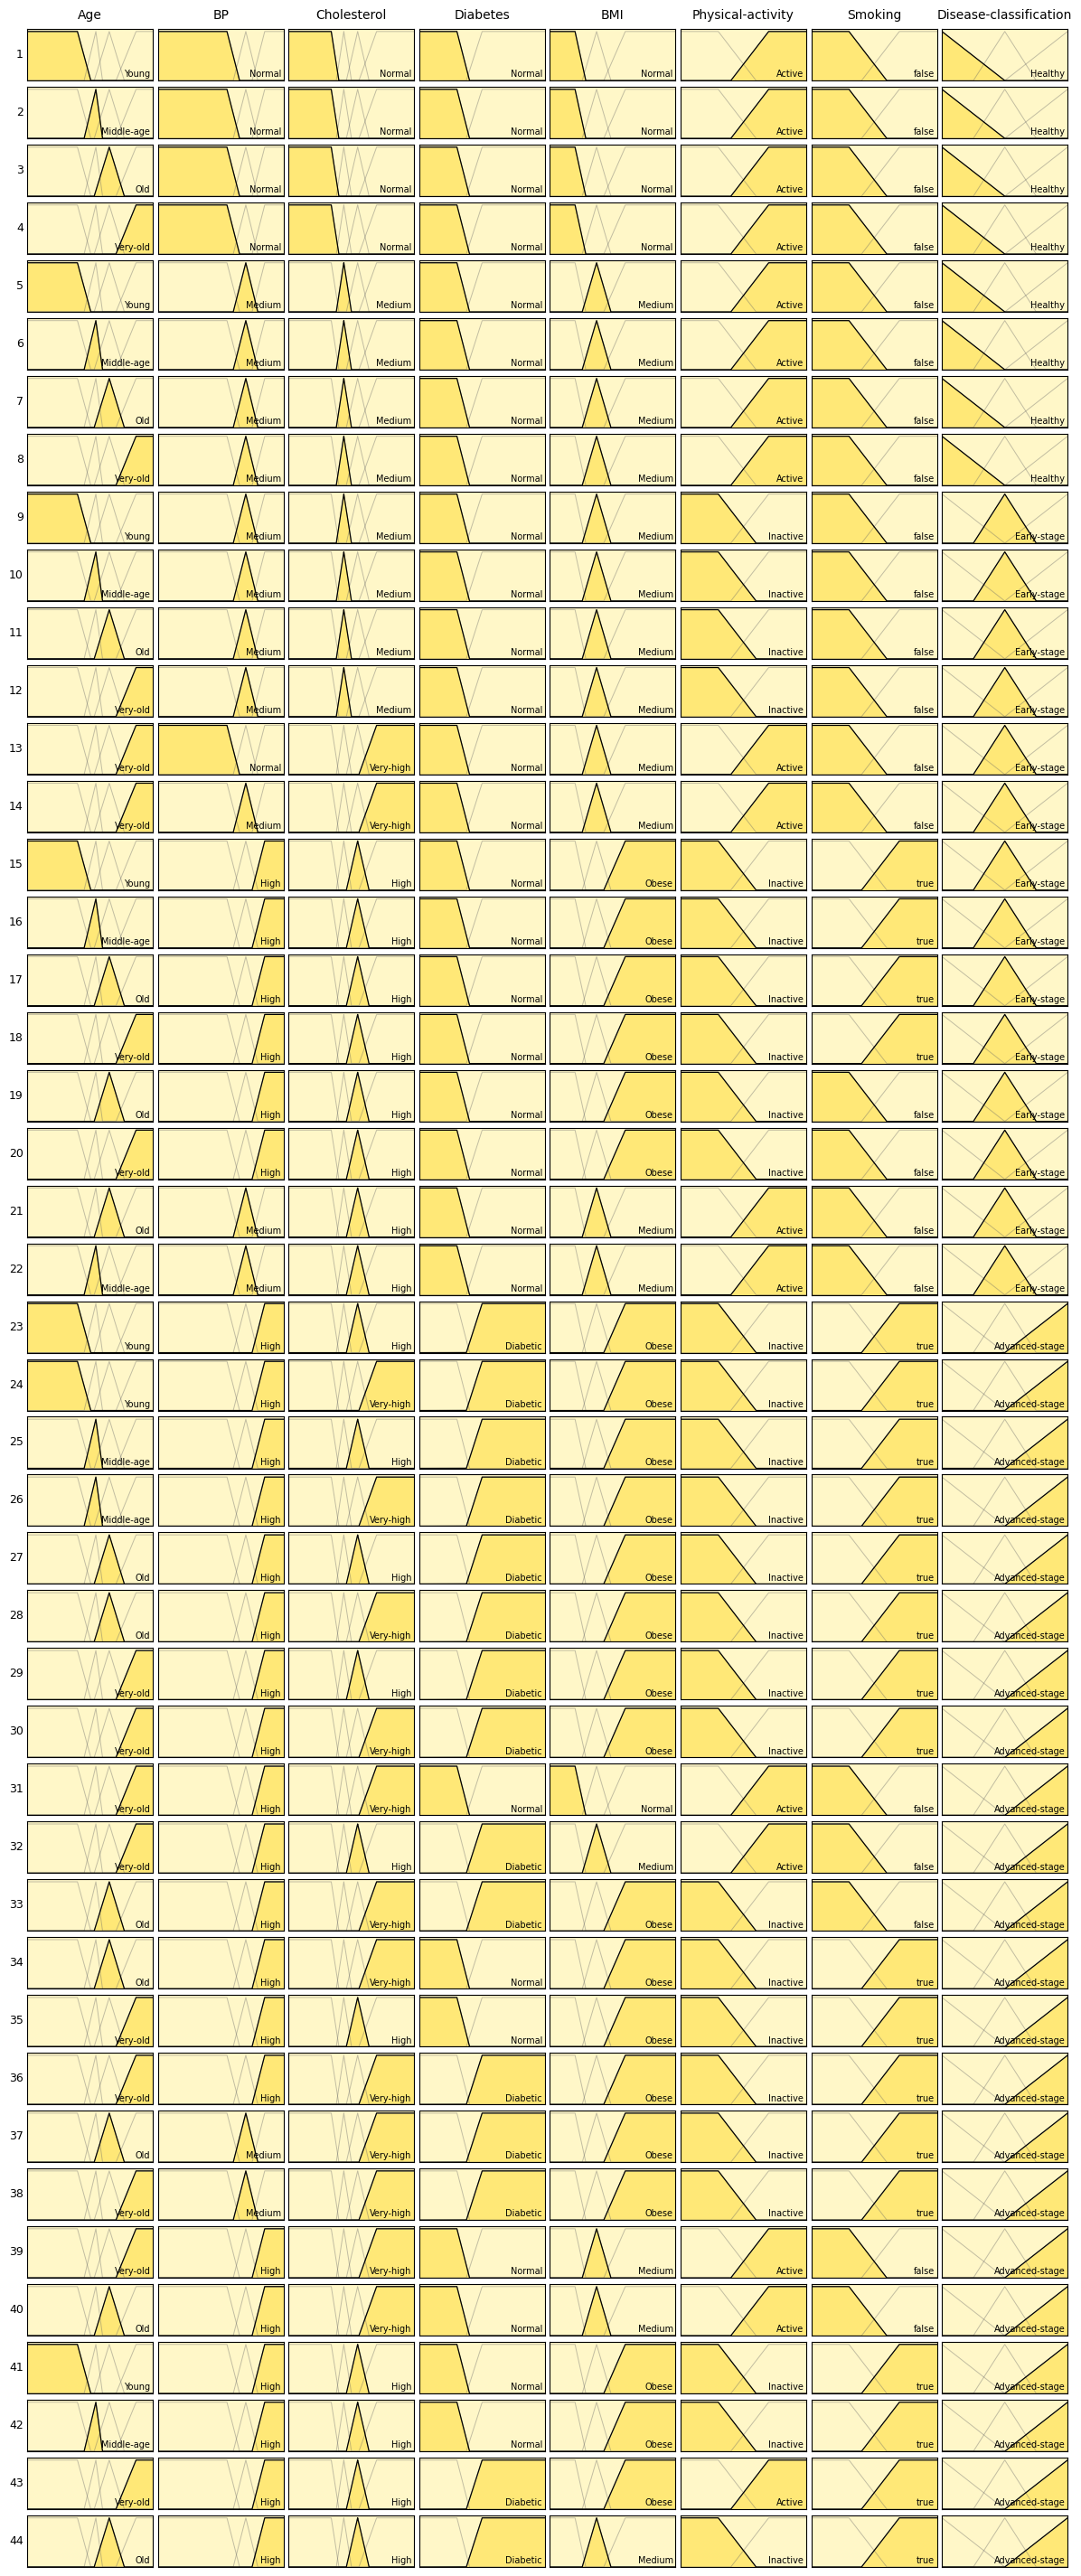

Saved: /content/figs/rule_grid_paper_logic.png


In [9]:
# ===========================================
# Paper-style RULE GRID (44 rules, 7→1 system)
# ===========================================
!pip -q install scikit-fuzzy numpy matplotlib

import numpy as np, skfuzzy as fuzz, matplotlib.pyplot as plt, os
outdir = "/content/figs"; os.makedirs(outdir, exist_ok=True)

# ---------- Universes ----------
x_age   = np.linspace(0, 75, 751)        # years
x_bp    = np.linspace(0, 200, 2001)      # mmHg
x_chol  = np.linspace(0, 500, 5001)      # mg/dL
x_glu   = np.linspace(0, 400, 4001)      # mg/dL (diabetes proxy)
x_bmi   = np.linspace(15, 50, 701)       # kg/m^2
x_pa    = np.linspace(0, 1, 1001)        # 0..1 (Inactive..Active)
x_smk   = np.linspace(0, 1, 1001)        # 0..1 (false..true)
x_out   = np.linspace(0, 2, 401)         # 0 Healthy, 1 Early, 2 Advanced

# ---------- Membership functions (matching the paper) ----------
mf_age = {
    "Young":     (x_age,  fuzz.trapmf(x_age, [0, 0, 30, 38])),
    "Middle-age":(x_age,  fuzz.trimf(x_age, [34, 41, 45])),
    "Old":       (x_age,  fuzz.trimf(x_age, [40, 49, 58])),
    "Very-old":  (x_age,  fuzz.trapmf(x_age, [53, 65, 75, 75])),
}
mf_bp = {
    "Normal": (x_bp,  fuzz.trapmf(x_bp, [0, 0, 110, 130])),
    "Medium": (x_bp,  fuzz.trimf(x_bp, [120, 140, 159])),
    "High":   (x_bp,  fuzz.trapmf(x_bp, [150, 170, 200, 200])),
}
mf_chol = {
    "Normal":     (x_chol, fuzz.trapmf(x_chol, [0, 0, 170, 200])),
    "Medium":     (x_chol, fuzz.trimf(x_chol, [190, 220, 250])),
    "High":       (x_chol, fuzz.trimf(x_chol, [230, 275, 320])),
    "Very-high":  (x_chol, fuzz.trapmf(x_chol, [280, 350, 500, 500])),
}
mf_glu = {
    "Normal":   (x_glu, fuzz.trapmf(x_glu, [0, 0, 120, 160])),
    "Diabetic": (x_glu, fuzz.trapmf(x_glu, [150, 200, 400, 400])),
}
mf_bmi = {
    "Normal": (x_bmi, fuzz.trapmf(x_bmi, [15, 15, 22, 25])),
    "Medium": (x_bmi, fuzz.trimf(x_bmi, [24, 28, 32])),
    "Obese":  (x_bmi, fuzz.trapmf(x_bmi, [30, 36, 50, 50])),
}
mf_pa = {
    "Inactive": (x_pa, fuzz.trapmf(x_pa, [0, 0, 0.3, 0.6])),
    "Active":   (x_pa, fuzz.trapmf(x_pa, [0.4, 0.7, 1, 1])),
}
mf_smk = {
    "false": (x_smk, fuzz.trapmf(x_smk, [0, 0, 0.3, 0.6])),
    "true":  (x_smk, fuzz.trapmf(x_smk, [0.4, 0.7, 1, 1])),
}
mf_out = {
    "Healthy":        (x_out, fuzz.trimf(x_out, [0, 0, 1])),
    "Early-stage":    (x_out, fuzz.trimf(x_out, [0.5, 1, 1.5])),
    "Advanced-stage": (x_out, fuzz.trimf(x_out, [1, 2, 2])),
}

cols = ["Age","BP","Cholesterol","Diabetes","BMI","Physical-activity","Smoking","Disease-classification"]
mf_map = {
    "Age": mf_age, "BP": mf_bp, "Cholesterol": mf_chol, "Diabetes": mf_glu,
    "BMI": mf_bmi, "Physical-activity": mf_pa, "Smoking": mf_smk,
    "Disease-classification": mf_out,
}

# ---------- Build a 44-rule set that mirrors the paper’s logic ----------
rules = []

def add_rule(age,bp,chol,glu,bmi,pa,smk,outcome):
    rules.append({"Age":age,"BP":bp,"Cholesterol":chol,"Diabetes":glu,
                  "BMI":bmi,"Physical-activity":pa,"Smoking":smk,
                  "Disease-classification":outcome})

# Healthy (8 rules): all-normal profile across ages; + mild variant
for a in ["Young","Middle-age","Old","Very-old"]:
    add_rule(a,"Normal","Normal","Normal","Normal","Active","false","Healthy")
for a in ["Young","Middle-age","Old","Very-old"]:
    add_rule(a,"Medium","Medium","Normal","Medium","Active","false","Healthy")

# Early-stage (16 rules): moderate patterns incl. very-old + very-high chol at normal/medium BP
for a in ["Young","Middle-age","Old","Very-old"]:
    add_rule(a,"Medium","Medium","Normal","Medium","Inactive","false","Early-stage")
for bp in ["Normal","Medium"]:
    add_rule("Very-old", bp, "Very-high", "Normal", "Medium", "Active", "false", "Early-stage")
# young/middle/old with high BP & high chol but non-diabetic → early (if inactive & smoking)
for a in ["Young","Middle-age","Old","Very-old"]:
    add_rule(a,"High","High","Normal","Obese","Inactive","true","Early-stage")
# old with high BP & high chol & diabetic absent? (paper shows a few early even w/ high vitals)
add_rule("Old","High","High","Normal","Obese","Inactive","false","Early-stage")
add_rule("Very-old","High","High","Normal","Obese","Inactive","false","Early-stage")
# old + medium BP + high chol (active, NS) → early
add_rule("Old","Medium","High","Normal","Medium","Active","false","Early-stage")
add_rule("Middle-age","Medium","High","Normal","Medium","Active","false","Early-stage")

# Advanced-stage (20 rules): high-risk combos per paper
# any age with high BP or very-high chol + diabetic/obese/inactive/smoker
for a in ["Young","Middle-age","Old","Very-old"]:
    add_rule(a,"High","High","Diabetic","Obese","Inactive","true","Advanced-stage")
    add_rule(a,"High","Very-high","Diabetic","Obese","Inactive","true","Advanced-stage")
# very-old severe even if active/non-smoker/normal BMI (paper had such)
add_rule("Very-old","High","Very-high","Normal","Normal","Active","false","Advanced-stage")
add_rule("Very-old","High","High","Diabetic","Medium","Active","false","Advanced-stage")
# old severe
add_rule("Old","High","Very-high","Diabetic","Obese","Inactive","false","Advanced-stage")
add_rule("Old","High","Very-high","Normal","Obese","Inactive","true","Advanced-stage")
# very-old + obese + inactive + smoker with high vitals
add_rule("Very-old","High","High","Normal","Obese","Inactive","true","Advanced-stage")
add_rule("Very-old","High","Very-high","Diabetic","Obese","Inactive","true","Advanced-stage")
# high chol at medium BP + diabetic -> advanced
for a in ["Old","Very-old"]:
    add_rule(a,"Medium","Very-high","Diabetic","Obese","Inactive","true","Advanced-stage")
# high BP + very-high chol + not diabetic + active NS -> still advanced (paper shows this)
add_rule("Very-old","High","Very-high","Normal","Medium","Active","false","Advanced-stage")
add_rule("Old","High","Very-high","Normal","Medium","Active","false","Advanced-stage")
# smoker + inactive + high BP + high chol (young & middle too) -> advanced
add_rule("Young","High","High","Normal","Obese","Inactive","true","Advanced-stage")
add_rule("Middle-age","High","High","Normal","Obese","Inactive","true","Advanced-stage")
# very-old + high BP + high chol + diabetic + obese + active (still advanced)
add_rule("Very-old","High","High","Diabetic","Obese","Active","true","Advanced-stage")
# old + high BP + high chol + diabetic + medium BMI + inactive + smoker
add_rule("Old","High","High","Diabetic","Medium","Inactive","true","Advanced-stage")

print("Total rules:", len(rules))  # should be 44

# ---------- Drawing helpers ----------
def yellow_axes(ax):
    ax.set_facecolor("#FFF7C8")
    ax.set_yticks([]); ax.set_xticks([])
    ax.set_xlim(0, 1); ax.set_ylim(0, 1.05)

def norm01(x): return (x - x.min()) / (x.max() - x.min() + 1e-12)

def draw_panel(ax, mf_dict, chosen_key):
    # all mfs (grey)
    for key, (xg, yg) in mf_dict.items():
        ax.plot(norm01(xg), yg, lw=0.7, color="#666", alpha=0.4)
    # chosen (yellow fill + black edge)
    xg, yg = mf_dict[chosen_key]
    ax.fill_between(norm01(xg), 0, yg, color="#FFE873", alpha=0.95, lw=0)
    ax.plot(norm01(xg), yg, color="black", lw=0.9)
    # tiny label
    ax.text(0.98, 0.03, chosen_key, ha="right", va="bottom", fontsize=7, transform=ax.transAxes)

# ---------- Plot grid ----------
n_rules, n_cols = len(rules), len(cols)
fig_height = max(12, 0.65 * n_rules)  # scale height with rule count
fig, axes = plt.subplots(n_rules, n_cols, figsize=(12, fig_height))
if n_rules == 1: axes = np.array([axes])
for c, col in enumerate(cols):
    axes[0, c].set_title(col, fontsize=10, pad=8)

for r_idx, rule in enumerate(rules):
    for c_idx, col in enumerate(cols):
        ax = axes[r_idx, c_idx]; yellow_axes(ax)
        draw_panel(ax, mf_map[col], rule[col])
        if c_idx == 0:  # row index
            ax.text(-0.03, 0.5, f"{r_idx+1}", ha="right", va="center", fontsize=9, transform=ax.transAxes)

plt.tight_layout(h_pad=0.5, w_pad=0.4)
out_path = os.path.join(outdir, "rule_grid_paper_logic.png")
plt.savefig(out_path, dpi=220); plt.show()
print("Saved:", out_path)


In [4]:
!zip -r figs_bundle.zip /content/figs/*.png
from google.colab import files
files.download('figs_bundle.zip')


  adding: content/figs/rule_grid_paper_logic.png (deflated 2%)
  adding: content/figs/rule_grid.png (deflated 2%)
  adding: content/figs/surface_bp_chol_baseline.png (deflated 7%)
  adding: content/figs/surface_bp_chol_high_risk.png (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-4190334849.py:101: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  A = np.trapz(muarr, x)
/tmp/ipython-input-4190334849.py:102: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if A==0 else np.trapz(x*muarr, x)/A


Test sample size n = 149
KNN    -> Acc: 72.48% | Sens: 70.13% | Spec: 75.00% | Prec: 75.00%
SVM    -> Acc: 79.19% | Sens: 83.12% | Spec: 75.00% | Prec: 78.05%
Fuzzy  -> Acc: 52.35% | Sens: 83.12% | Spec: 19.44% | Prec: 52.46%


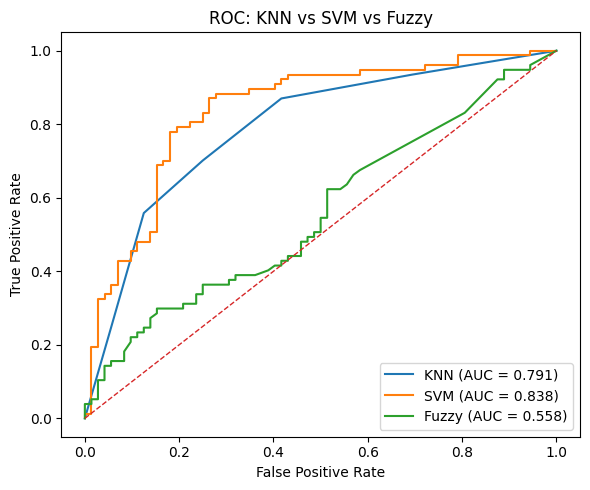

Saved ROC figure to /content/figs/roc_knn_svm_fuzzy.png


In [14]:
# =========================
# Metrics + ROC (KNN/SVM/Fuzzy)
# =========================
!pip -q install scikit-fuzzy numpy matplotlib scikit-learn

import numpy as np, pandas as pd, skfuzzy as fuzz, matplotlib.pyplot as plt, re, os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             confusion_matrix, roc_curve, auc)

assert 'dataset' in globals(), "Make sure your DataFrame is named `dataset`."

# ---------- 1) CLEAN & MAP ----------
df = dataset.copy()

# numeric coercion for basics
for c in ['age','trestbps','chol','num','oldpeak','ca','thalch']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# fbs (object) -> 0/1
def map_fbs(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    return 1 if re.match(r'^(1|true|t|yes|y|>?\s*120)$', s) else 0
df['fbs_bin'] = df['fbs'].apply(map_fbs) if 'fbs' in df.columns else np.nan

# restecg (object) -> {0,1,2}
def map_restecg(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    try:
        v = float(s)
        if v in [0,1,2]: return int(v)
    except: pass
    if 'normal' in s: return 0
    if 'lvh' in s or 'hypertrophy' in s: return 2
    if 'st' in s or 't' in s or 'abnorm' in s: return 1
    return np.nan
df['restecg_num'] = df['restecg'].apply(map_restecg) if 'restecg' in df.columns else np.nan

# exang (object) -> 0/1
def map_exang(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    return 1 if s in ['1','yes','true','t','y'] else 0
df['exang_bin'] = df['exang'].apply(map_exang) if 'exang' in df.columns else np.nan

# sex -> 0/1 if present
def map_sex(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    if s in ['1','m','male']: return 1
    if s in ['0','f','female']: return 0
    return np.nan
if 'sex' in df.columns:
    df['sex_bin'] = df['sex'].apply(map_sex)

# ground truth target (binary): 1 if num>0 else 0
if 'num' not in df.columns:
    raise ValueError("Expected 'num' column for labels.")
df['target'] = (df['num'] > 0).astype(int)

# ---------- 2) BASIC FUZZY SYSTEM (Age, BP, Chol, Diabetes proxy) ----------
# universes
x_age  = np.linspace(0, 75, 751)
x_bp   = np.linspace(0, 200, 2001)
x_chol = np.linspace(0, 500, 5001)
x_glu  = np.linspace(0, 400, 4001)
x_out  = np.linspace(0, 2, 401)

# MFs (as used earlier)
age_young    = fuzz.trapmf(x_age, [0, 0, 30, 38])
age_mid      = fuzz.trimf(x_age, [34, 41, 45])
age_old      = fuzz.trimf(x_age, [40, 49, 58])
age_very_old = fuzz.trapmf(x_age, [53, 65, 75, 75])

bp_normal = fuzz.trapmf(x_bp, [0, 0, 110, 130])
bp_med    = fuzz.trimf(x_bp, [120, 140, 159])
bp_high   = fuzz.trapmf(x_bp, [150, 170, 200, 200])

chol_norm = fuzz.trapmf(x_chol, [0, 0, 170, 200])
chol_med  = fuzz.trimf(x_chol, [190, 220, 250])
chol_high = fuzz.trimf(x_chol, [230, 275, 320])
chol_vhi  = fuzz.trapmf(x_chol, [280, 350, 500, 500])

glu_norm = fuzz.trapmf(x_glu, [0, 0, 120, 160])
glu_diag = fuzz.trapmf(x_glu, [150, 200, 400, 400])

y_healthy = fuzz.trimf(x_out, [0, 0, 1])
y_stage1  = fuzz.trimf(x_out, [0.5, 1, 1.5])
y_stage2  = fuzz.trimf(x_out, [1, 2, 2])

def mu(xg, mf, x): return float(np.interp(x, xg, mf))
def centroid(x, muarr):
    A = np.trapz(muarr, x)
    return 0.0 if A==0 else np.trapz(x*muarr, x)/A

def glucose_from_fbs_bin(b): return 180.0 if int(b)==1 else 100.0

def fuzzy_crisp(age, bp, chol, fbs_bin):
    # fuzzify
    Ay, Am, Ao, Avo = (mu(x_age, age_young, age),
                       mu(x_age, age_mid, age),
                       mu(x_age, age_old, age),
                       mu(x_age, age_very_old, age))
    BPn, BPm, BPh = (mu(x_bp, bp_normal, bp),
                     mu(x_bp, bp_med, bp),
                     mu(x_bp, bp_high, bp))
    Cn, Cm, Ch, Cvh = (mu(x_chol, chol_norm, chol),
                       mu(x_chol, chol_med, chol),
                       mu(x_chol, chol_high, chol),
                       mu(x_chol, chol_vhi, chol))
    glu = glucose_from_fbs_bin(fbs_bin)
    Gn, Gd = (mu(x_glu, glu_norm, glu), mu(x_glu, glu_diag, glu))

    # rules (same compact set as before)
    r1 = min(BPn, Cn, Gn, max(Ay, Am))                     # Healthy
    r2 = min(max(BPm, Cm), Gn)                             # Stage1
    r3 = max(BPh, max(Ch, Cvh))                            # Stage2
    r4 = min(Gd, max(BPm, Cm))                             # Stage2
    r5 = min(Avo, max(BPm, Cm))                            # Stage1
    r6 = min(Avo, max(BPh, max(Ch, Cvh)))                  # Stage2
    r7 = min(Ao, max(BPm, Cm), Gn)                         # Stage1
    r8 = min(Gd, min(BPn, Cn))                             # Stage1

    mu_H  = np.fmin(r1, y_healthy)
    mu_S1 = np.fmin(max(r2, r5, r7, r8), y_stage1)
    mu_S2 = np.fmin(max(r3, r4, r6), y_stage2)
    agg = np.maximum(mu_H, np.maximum(mu_S1, mu_S2))
    return centroid(x_out, agg)  # 0..2

# ---------- 3) BUILD FEATURE SET FOR KNN/SVM ----------
# Keep rows with core inputs for fuzzy + ML
core = ['age','trestbps','chol','fbs_bin','target']
df_core = df.dropna(subset=core).copy()

# Extra features for ML if present (we'll impute later via pipeline)
feat_candidates = ['age','trestbps','chol','fbs_bin','restecg_num','exang_bin','thalch','oldpeak','ca','sex_bin']
features = [c for c in feat_candidates if c in df_core.columns]
X = df_core[features].astype(float).values
y = df_core['target'].astype(int).values

# Train / test split and get indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X, y, df_core.index, test_size=0.2, stratify=y, random_state=42
)

# Create df_test using the test indices
df_test = df_core.loc[test_indices, ['age','trestbps','chol','fbs_bin']]


# Pipelines (with imputation and scaling)
pipe_knn = Pipeline([('imputer', SimpleImputer(strategy='median')), # Add imputer
                     ('scaler', StandardScaler()),
                     ('clf', KNeighborsClassifier(n_neighbors=5))])
pipe_svm = Pipeline([('imputer', SimpleImputer(strategy='median')), # Add imputer
                     ('scaler', StandardScaler()),
                     ('clf', SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42))])

pipe_knn.fit(X_train, y_train)
pipe_svm.fit(X_train, y_train)

# Probabilities / scores
proba_knn = pipe_knn.predict_proba(X_test)[:,1]
proba_svm = pipe_svm.predict_proba(X_test)[:,1]

# Fuzzy scores on the SAME test rows (scale crisp 0..2 down to 0..1)
fuzzy_crisps = []
for (_, row_vals) in df_test.iterrows():
    crisp = fuzzy_crisp(float(row_vals['age']), float(row_vals['trestbps']),
                        float(row_vals['chol']), int(row_vals['fbs_bin']))
    fuzzy_crisps.append(crisp/2.0)  # 0..1 score

fuzzy_scores = np.array(fuzzy_crisps)

# ---------- 4) METRICS ----------
# binary predictions (0.5 threshold)
pred_knn  = (proba_knn >= 0.5).astype(int)
pred_svm  = (proba_svm >= 0.5).astype(int)
pred_fuzz = (fuzzy_scores >= 0.5).astype(int)

def metrics(y_true, y_pred):
    acc  = accuracy_score(y_true, y_pred)
    sens = recall_score(y_true, y_pred)            # TPR
    spec = recall_score(1-y_true, 1-y_pred)        # TNR
    prec = precision_score(y_true, y_pred)
    return acc, sens, spec, prec

m_knn  = metrics(y_test, pred_knn)
m_svm  = metrics(y_test, pred_svm)
m_fuzz = metrics(y_test, pred_fuzz)

n_test = len(y_test)
print(f"Test sample size n = {n_test}")
print(f"KNN    -> Acc: {m_knn[0]*100:.2f}% | Sens: {m_knn[1]*100:.2f}% | Spec: {m_knn[2]*100:.2f}% | Prec: {m_knn[3]*100:.2f}%")
print(f"SVM    -> Acc: {m_svm[0]*100:.2f}% | Sens: {m_svm[1]*100:.2f}% | Spec: {m_svm[2]*100:.2f}% | Prec: {m_svm[3]*100:.2f}%")
print(f"Fuzzy  -> Acc: {m_fuzz[0]*100:.2f}% | Sens: {m_fuzz[1]*100:.2f}% | Spec: {m_fuzz[2]*100:.2f}% | Prec: {m_fuzz[3]*100:.2f}%")

# ---------- 5) ROC CURVES ----------
fpr_knn, tpr_knn, _ = roc_curve(y_test, proba_knn)
fpr_svm, tpr_svm, _ = roc_curve(y_test, proba_svm)
fpr_fuz, tpr_fuz, _ = roc_curve(y_test, fuzzy_scores)

auc_knn = auc(fpr_knn, tpr_knn)
auc_svm = auc(fpr_svm, tpr_svm)
auc_fuz = auc(fpr_fuz, tpr_fuz)

plt.figure(figsize=(6,5))
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.3f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.3f})')
plt.plot(fpr_fuz, tpr_fuz, label=f'Fuzzy (AUC = {auc_fuz:.3f})')
plt.plot([0,1],[0,1],'--', linewidth=1)  # chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC: KNN vs SVM vs Fuzzy")
plt.legend(loc="lower right")
os.makedirs("/content/figs", exist_ok=True)
plt.tight_layout(); plt.savefig("/content/figs/roc_knn_svm_fuzzy.png", dpi=180)
plt.show()

print("Saved ROC figure to /content/figs/roc_knn_svm_fuzzy.png")